# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


### Notebook Configuration

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

## Import Packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import pathlib as pal
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Helper Functions

In [3]:
def color_select(img, thres_low, thres_high):
    """
    Selects an RGB color range from the input image and
    converts the selection into a single channel image.
    """
    mask = cv2.inRange(img, thres_low, thres_high)
    masked_img = cv2.bitwise_and(img, img, mask = mask)
    return cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, horizon, color=[255, 0, 0]):
    """
    This function draws `lines` with `color` onto `img` inplace.    
    
    The detected line segments are filtered depending on their position in the image and their slope.
    The lines for the left/right halfes are extrapolated and averaged and finally drawn onto the image.
    """
    
    # width of the image
    w = img.shape[1]
    # height of the image
    h = img.shape[0]
    
    left_and_right_lines = ([], [])
   
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            slope = (y2-y1)/(x2-x1)
         
            # reject vertical as well as too "flat/horizontal" lines
            if x1 == x2 or abs(slope) < 0.5:
                continue
                
            # reject lines in the right half of the image with negative slope
            if slope < 0.0 and x2 > w/2:
                continue
            
            # reject lines in the left half of the image with positive slope
            if slope > 0.0 and x2 < w/2:
                continue

            # collect line segment properties required for averaging and extrapolation
            intercept = y2 - slope*x2
            min_y = min(y1, y2)
            max_y = max(y1, y2)
            x_bottom = (h - intercept) / slope
            
            # define a "weight" based on the vertical length of the segment
            weight = abs(y2 - y1)
            
            line_data = (slope, intercept, min_y, x_bottom, weight)
            
            # partition the detected segments into left and right lane lines based on their slope
            left_and_right_lines[int(slope < 0.0)].append(line_data)
            
            # uncomment to draw the raw lines from the hugh transformation
            #cv2.line(img, (x1, y1), (x2, y2), color, 2)
    
    
    # for both the left and right half of the image, extrapolate and draw one
    # averaged line
    
    for filtered_lines in left_and_right_lines:
        if (len(filtered_lines) < 2):
            continue
     
        # now we average (weighted) and extrapolate the detected line segments
        # from either half of the image
        # let's start with the averaged slope and intercept
        filtered_lines = np.array(filtered_lines)
     
        slope     = np.average(filtered_lines[:,0], weights=filtered_lines[:,4]);
        intercept = np.average(filtered_lines[:,1], weights=filtered_lines[:,4]);
                
        # now for the top and bottom y coordinate
        top_y     = horizon * h
        bottom_y     = h;
        
        # uncomment to limit the upper end of the line to the uppermost detected line segment
        #top_y     = np.amin(filtered_lines[:,2]);

        # calculate
        top_x = (top_y-intercept) / slope
        bottom_x = (bottom_y-intercept) / slope
        
        # calculate the horizontal weighted standard deviation of the intercept with the image bottom
        x_bottom   = np.average(filtered_lines[:,3], weights=filtered_lines[:,4]);
        variance_x = np.average((filtered_lines[:,3]-x_bottom)**2, weights=filtered_lines[:,4])
        stddev_x = np.sqrt(variance_x) if np.isfinite(variance_x) else 0.0
        
        # set the line thickness based on that standard deviation
        line_thickness = max(6, int(0.3*stddev_x))
     
        # draw the averaged and extrapolated lines
        cv2.line(img, (int(top_x), int(top_y)), (int(bottom_x), int(bottom_y)), color, line_thickness)
                       
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, horizon):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    draw_lines(line_img, lines, horizon)
    
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



In [11]:
def pipeline(img):
    """
    Process a single image through the complete pipeline.
    """
    
    # image dimensions
    h = img.shape[0]
    w = img.shape[1]
    
    # relative y-position of the (hard-coded) line horizon
    horizon = 0.62;
    
    # the region of interest as a trapezoid
    region = np.array( [ \
                        [0.05*w, 1.0*h], \
                        [0.45*w, horizon*h], \
                        [0.55*w, horizon*h], \
                        [0.95*w, 1.0*h] \
                       ], dtype=np.int32 )
    
    #plt.figure()
    #plt.imshow(img)
    
    # select color (filtering dark parts of the image but allowing darker yet yellowish areas)
    proc_img = color_select(img, (130, 130, 40), (255, 255, 255))
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # cut region to the configure trapezoid
    proc_img = region_of_interest(proc_img, [region])
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # apply Gaussian blur
    proc_img = gaussian_blur(proc_img, 5)
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # apply Canny Edge
    proc_img = canny(proc_img, 50, 130)
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # detect line segments with Hough Transform (allowing relatively short lines as well)
    # and filter/extrapolate
    proc_img = hough_lines(proc_img, 2, np.pi/180, 30, 20, 5, horizon)
    
    #plt.figure()
    #plt.imshow(proc_img, cmap='gray')
    
    # overlay the extrapolated lane lines onto the original image
    proc_img = weighted_img(proc_img, img, 0.7, 1.0)
    
    return proc_img

## Execute on Images
Executing the pipeline on all images in 'test_images'.

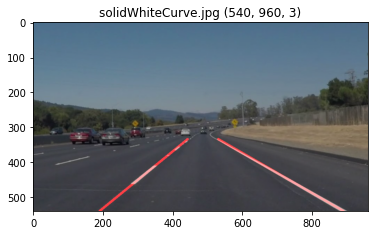

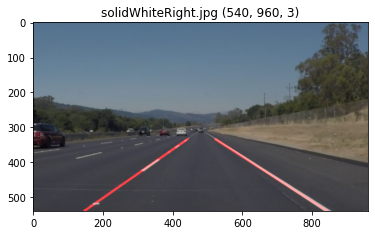

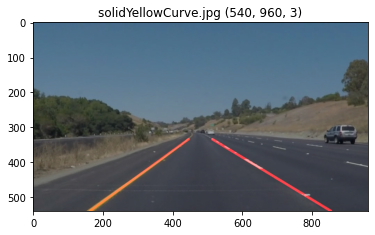

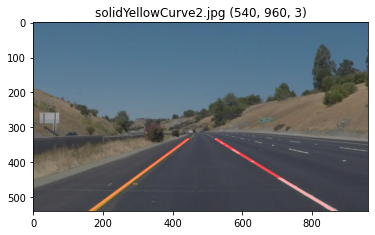

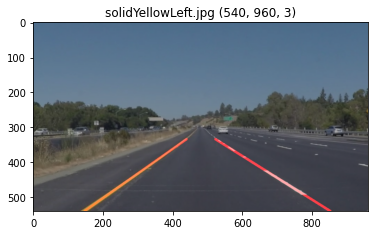

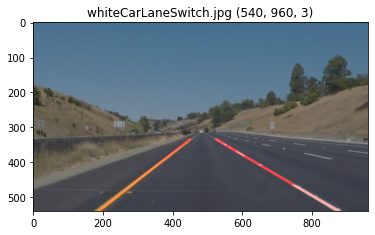

In [9]:
# apply the processing pipe line to all images in the input directory

input_dir = 'test_images'
output_dir = 'test_images_output'

for file in sorted(pal.Path(input_dir).iterdir()):

    # read and process
    image = mpimg.imread(str(file))
    image = pipeline(image)
    
    # plot in notebook
    plt.figure()
    plt.title("{} {}".format(file.name, image.shape))
    plt.imshow(image)
    
    # write to file
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_dir + '/' + file.name, image)

## Execute on Videos
Executing the pipeline on all videos in 'test_videos', including **the challenge**!

In [12]:
# apply the processing pipe line to all videos in the input directory

input_dir = 'test_videos'
output_dir = 'test_videos_output'

for file in sorted(pal.Path(input_dir).iterdir()):
    
    print('Parsing video "', file, '" with dimensions ', sep='')
    clip = VideoFileClip(str(file))
    #clip = VideoFileClip(str(file)).subclip(0,5)
    
    file_output = output_dir + '/' + file.name
    clip_output = clip.fl_image(pipeline)
    
    %time clip_output.write_videofile(file_output, audio=False)    

    display(HTML("""
<div>{1}</div>
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(file_output, file_output)))
    print()

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Parsing video "test_videos/01-solidWhiteRight.mp4" with dimensions 
Moviepy - Building video test_videos_output/01-solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/01-solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/01-solidWhiteRight.mp4
CPU times: user 4.19 s, sys: 945 ms, total: 5.13 s
Wall time: 2.54 s


t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]


Parsing video "test_videos/02-solidYellowLeft.mp4" with dimensions 
Moviepy - Building video test_videos_output/02-solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/02-solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/02-solidYellowLeft.mp4
CPU times: user 17.3 s, sys: 4.35 s, total: 21.7 s
Wall time: 10.5 s



Parsing video "test_videos/03-challenge.mp4" with dimensions 
Moviepy - Building video test_videos_output/03-challenge.mp4.
Moviepy - Writing video test_videos_output/03-challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/03-challenge.mp4
CPU times: user 9.01 s, sys: 1.79 s, total: 10.8 s
Wall time: 7.62 s


We are done!